In [1]:
!nvidia-smi

Mon Dec  9 05:02:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8              13W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="92jyh8UFL7X56QYAPtge")
project = rf.workspace("rf-projects").project("pcb-holes")
version = project.version(3)
dataset = version.download("coco")


loading Roboflow workspace...
loading Roboflow project...


In [3]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-hau9yyvc
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-hau9yyvc
  Resolved https://github.com/facebookresearch/detectron2.git to commit c69939aa85460e8135f40bce908a6cddaa73065f
  Preparing metadata (setup.py) ... done


In [4]:
import os
import json
import cv2
import random
import numpy as np
import torch
from google.colab.patches import cv2_imshow
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset


In [5]:
# Set the dataset paths
data_dir = "./PCB-Holes-3"
train_json = os.path.join(data_dir, "train/_annotations.coco.json")
val_json = os.path.join(data_dir, "valid/_annotations.coco.json")
train_img_dir = os.path.join(data_dir, "train")
val_img_dir = os.path.join(data_dir, "valid")

# Register datasets
register_coco_instances("pcb_train", {}, train_json, train_img_dir)
register_coco_instances("pcb_val", {}, val_json, val_img_dir)

pcb_metadata = MetadataCatalog.get("pcb_train")
dataset_dicts = DatasetCatalog.get("pcb_train")
print("Number of training images:", len(dataset_dicts))


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



Number of training images: 158


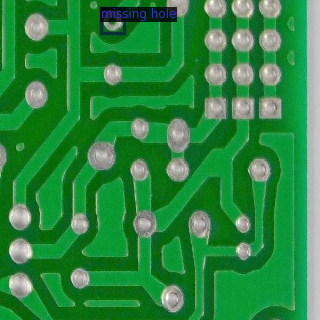

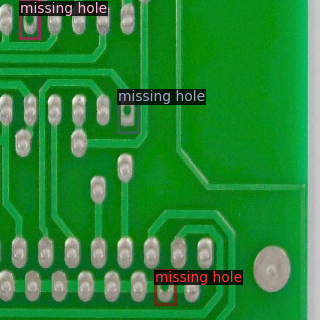

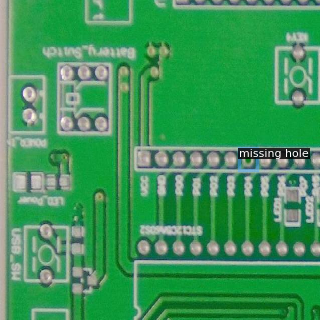

In [6]:
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=pcb_metadata, scale=0.5, instance_mode=ColorMode.IMAGE)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])


In [7]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("pcb_train",)
cfg.DATASETS.TEST = ("pcb_val",)
cfg.DATALOADER.NUM_WORKERS = 2

# Use a pretrained COCO model as a starting point
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # Might adjust based on dataset
cfg.SOLVER.MAX_ITER = 3000    # Adjust based on dataset size
cfg.SOLVER.STEPS = []         # No LR step down
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  # Default: 512, might try smaller
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # Set to number of classes in your PCB dataset

cfg.OUTPUT_DIR = "./output_pcb_holes"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


In [8]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


[12/09 05:03:17 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[12/09 05:03:17 d2.engine.train_loop]: Starting training from iteration 0


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)


[12/09 05:03:29 d2.utils.events]:  eta: 0:21:28  iter: 19  total_loss: 1.445  loss_cls: 1.147  loss_box_reg: 0.1405  loss_rpn_cls: 0.1369  loss_rpn_loc: 0.008943    time: 0.4253  last_time: 0.3541  data_time: 0.0413  last_data_time: 0.0242   lr: 4.9953e-06  max_mem: 1737M
[12/09 05:03:41 d2.utils.events]:  eta: 0:17:48  iter: 39  total_loss: 1.333  loss_cls: 1.013  loss_box_reg: 0.162  loss_rpn_cls: 0.1437  loss_rpn_loc: 0.01438    time: 0.3757  last_time: 0.2867  data_time: 0.0119  last_data_time: 0.0048   lr: 9.9902e-06  max_mem: 1738M
[12/09 05:03:48 d2.utils.events]:  eta: 0:16:46  iter: 59  total_loss: 1.124  loss_cls: 0.7453  loss_box_reg: 0.1883  loss_rpn_cls: 0.1328  loss_rpn_loc: 0.009897    time: 0.3589  last_time: 0.3812  data_time: 0.0075  last_data_time: 0.0054   lr: 1.4985e-05  max_mem: 1738M
[12/09 05:03:56 d2.utils.events]:  eta: 0:17:26  iter: 79  total_loss: 0.8402  loss_cls: 0.5516  loss_box_reg: 0.1631  loss_rpn_cls: 0.07978  loss_rpn_loc: 0.006549    time: 0.3681  

In [9]:
# Load the trained weights
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

evaluator = COCOEvaluator("pcb_val", cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "pcb_val")
inference_on_dataset(predictor.model, val_loader, evaluator)


[12/09 05:19:40 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output_pcb_holes/model_final.pth ...


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


WARNING [12/09 05:19:40 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [12/09 05:19:40 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/09 05:19:40 d2.data.datasets.coco]: Loaded 20 images in COCO format from ./PCB-Holes-3/valid/_annotations.coco.json
[12/09 05:19:40 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/09 05:19:40 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/09 05:19:40 d2.data.common]: Serializing 20 elements to byte tensors and concatenating them all ...
[12/09 05:19:40 d2.data.common]: Serialized dataset takes 0.01 MiB
[12/09 05:19:40 d2.evaluation.evaluator]: Start inference on 20 batches
[12/09 05:19:42 d2.evaluation.ev

OrderedDict([('bbox',
              {'AP': 71.45369309750119,
               'AP50': 95.84629891560581,
               'AP75': 93.96039603960394,
               'APs': nan,
               'APm': 71.4871272874051,
               'APl': nan,
               'AP-Holes': nan,
               'AP-missing hole': 71.45369309750119})])

WARNING [12/09 05:19:42 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/09 05:19:42 d2.data.datasets.coco]: Loaded 20 images in COCO format from ./PCB-Holes-3/valid/_annotations.coco.json


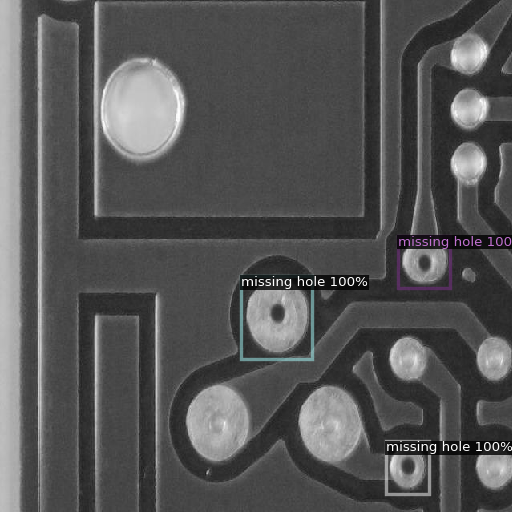

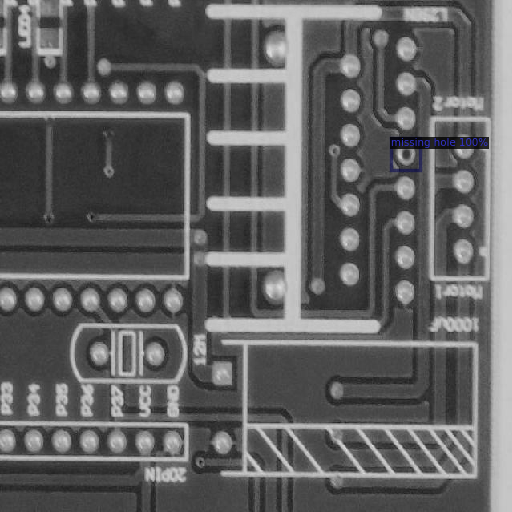

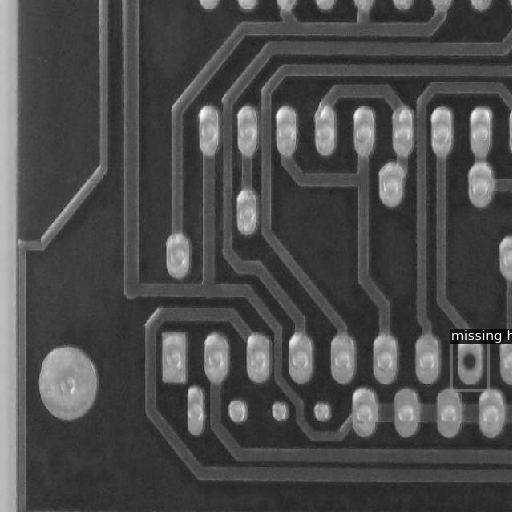

In [10]:
dataset_dicts_val = DatasetCatalog.get("pcb_val")
for d in random.sample(dataset_dicts_val, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=pcb_metadata,
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE_BW)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])
